In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Starter Code

In [4]:
words = open("../../makemore/names.txt", "r").read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [5]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
block_size = 8
def build_dataset(words):  

  X, Y = [], []
  
  for w in words:

    context = [0] * block_size
    for ch in w + '.':

      ix = stoi[ch]

      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X.to(device), Y.to(device)

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
@torch.no_grad()
def split_loss(split, model):
    x, y = {
        "train": (Xtr, Ytr),
        "valid": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    return loss.item()

In [8]:
def sample(model):
    # sampling from the model
    for _ in range(20):
        out = []
        context = [0] * block_size
        while True:
            # Forward pass
            logits = model(torch.tensor([context]).to(device))
            probs = F.softmax(logits, dim = 1)

            ix = torch.multinomial(probs, num_samples = 1).item()

            # Shift the Context Window
            context = context[1:] + [ix]

            if ix == 0:
                break

            out.append(ix)
        
        print("".join(itos[i] for i in out))
        

# E01: using torch.nn Module instead of custom classes

- I commented the batchnorm parts since it (surprisingly) made the model worse
- the transpose lines before and after the batchnorm since the implementation of custom class `BatchNorm1d` in the original video has the input in format (N, L, C) instead of (N, C, L) as in the torch implementation

In [75]:
import torch.nn.init as init

class Model(torch.nn.Module):
    def __init__(self, vocab_size, n_embed, n_hidden):
        super(Model, self).__init__()

        self.embed = torch.nn.Embedding(vocab_size, n_embed)
        self.tanh = torch.nn.Tanh()

        self.batchnorm1 = torch.nn.BatchNorm1d(n_hidden)
        self.batchnorm2 = torch.nn.BatchNorm1d(n_hidden)
        self.batchnorm3 = torch.nn.BatchNorm1d(n_hidden)

        self.fc1 = torch.nn.Linear(n_embed * 2, n_hidden, bias=False)
        init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='tanh')
        self.fc2 = torch.nn.Linear(n_hidden * 2, n_hidden, bias=False)
        init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='tanh')
        self.fc3 = torch.nn.Linear(n_hidden * 2, n_hidden, bias=False)
        init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='tanh')
        self.fc4 = torch.nn.Linear(n_hidden, vocab_size, bias=False)
        

    def forward(self, x):
        # Embedding
        x = self.embed(x)

        # block 1
        x = self.flatten_consecutive(x)
        x = self.fc1(x)
        # x = x.transpose(1, 2)
        # x = self.batchnorm1(x)
        # x = x.transpose(1, 2)
        x = self.tanh(x)
        
        # block 2
        x = self.flatten_consecutive(x)
        x = self.fc2(x)
        # x = x.transpose(1, 2)
        # x = self.batchnorm2(x)
        # x = x.transpose(1, 2)
        x = self.tanh(x)

        # block 3
        x = self.flatten_consecutive(x)
        x = self.fc3(x)
        # x = self.batchnorm3(x)
        x = self.tanh(x)
        
        # output
        x = self.fc4(x)

        return x


    def flatten_consecutive(self, x):
        B, T, C = x.shape
        # swap 2nd and 3rd dimensions
        x = x.reshape(B, T // 2, C * 2)

        if x.shape[1] == 1:
            x = x.squeeze(1)

        return x

# E02: beating the 1.993 validation loss
I almost beat it (I got `1.990`) but the test loss is even better with `1.980`

In [229]:
n_embed = 32
n_hidden = 256

model = Model(vocab_size, n_embed, n_hidden).to(device)
model(Xtr[:10]);

torch.Size([10, 8])
torch.Size([10, 8, 32])
torch.Size([10, 8, 256])
torch.Size([10, 256, 7])
torch.Size([10, 256, 7])
torch.Size([10, 256, 7])
torch.Size([10, 256, 7])
torch.Size([10, 256, 7])
torch.Size([10, 256, 7])


In [217]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
train_losses = []
dev_losses = []

for epoch in range(100):
    model.train()

    for i in range(0, len(Xtr), 64):
        x = Xtr[i:i+64]
        y = Ytr[i:i+64]

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    train_loss = split_loss('train', model)
    dev_loss = split_loss('valid', model)
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)

    scheduler.step(dev_loss)

    print(f"epoch : {epoch} train_loss : {train_loss} dev_loss : {dev_loss}")

epoch : 0 train_loss : 2.2388224601745605 dev_loss : 2.2476375102996826
epoch : 1 train_loss : 2.1617937088012695 dev_loss : 2.1792397499084473
epoch : 2 train_loss : 2.116607666015625 dev_loss : 2.1417648792266846
epoch : 3 train_loss : 2.0833451747894287 dev_loss : 2.1160404682159424
epoch : 4 train_loss : 2.056706428527832 dev_loss : 2.096775531768799
epoch : 5 train_loss : 2.034327268600464 dev_loss : 2.081538677215576
epoch : 6 train_loss : 2.0148534774780273 dev_loss : 2.069016933441162
epoch : 7 train_loss : 1.9974969625473022 dev_loss : 2.0584826469421387
epoch : 8 train_loss : 1.981783390045166 dev_loss : 2.049513578414917
epoch : 9 train_loss : 1.967349886894226 dev_loss : 2.0418453216552734
epoch : 10 train_loss : 1.95401132106781 dev_loss : 2.035292863845825
epoch : 11 train_loss : 1.9415792226791382 dev_loss : 2.0297179222106934
epoch : 12 train_loss : 1.9299373626708984 dev_loss : 2.0249953269958496
epoch : 13 train_loss : 1.9189785718917847 dev_loss : 2.021010160446167
e

In [218]:
torch.save(model.state_dict(), "wave_net_bn_best_pth")

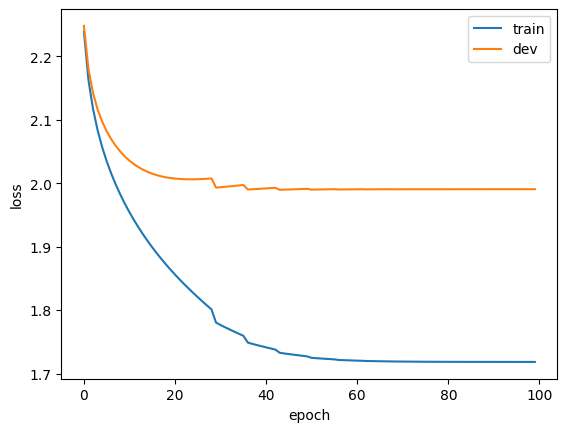

In [219]:
# plot train and dev losses
plt.plot(train_losses, label = 'train')
plt.plot(dev_losses, label = 'dev')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()

In [222]:
print(f"Training Loss: {split_loss('train', model):0.3f}")
print(f"Validation Loss: {split_loss('valid', model):0.3f}")
print(f"Test Loss: {split_loss('test', model):0.3f}")

Training Loss: 1.718
Validation Loss: 1.990
Test Loss: 1.980


In [223]:
sample(model)

pravel
walymar
edmon
ashbel
vetas
kanelai
zaeleigh
roslyn
yasmani
emrynn
reven
ashton
jaylynn
corina
mackenzie
izzam
amun
lyanne
pracie
hanai


# # E03: Using Convolutions

In [9]:
class ModelCnn(nn.Module):
    def __init__(self, vocab_size, n_embed, n_hidden, n_layers):
        super(ModelCnn, self).__init__()
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, n_embed)
        self.fc1 = nn.Linear(n_embed, n_hidden, bias=False)

        for i in range(n_layers):
            setattr(self, f"conv1d_{i}", nn.Conv1d(in_channels=n_hidden, out_channels=n_hidden, kernel_size=2, stride=2, bias=False, dilation=1, padding=0))
            setattr(self, f"bn{i}", nn.BatchNorm1d(n_hidden))
    

        self.fc2 = nn.Linear(n_hidden, vocab_size, bias=False)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.fc1(x)
        x = F.tanh(x)
        x = x.transpose(1,2)

        for i in range(self.n_layers):
            conv1d = getattr(self, f"conv1d_{i}")
            bn = getattr(self, f"bn{i}")
            x = conv1d(x)

            x = bn(x)
            x = F.tanh(x)

        x = x.squeeze(-1)
        x = self.fc2(x)
        return x

In [19]:
n_embed = 25
n_hidden = 80

model = ModelCnn(vocab_size= vocab_size, n_embed= n_embed, n_hidden= n_hidden, n_layers= 3).to(device)
model(Xtr[:10]);
train_losses = []
dev_losses = []

In [20]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

for epoch in range(100):
    model.train()

    for i in range(0, len(Xtr), 64):
        x = Xtr[i:i+64]
        y = Ytr[i:i+64]

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    train_loss = split_loss('train', model)
    dev_loss = split_loss('valid', model)
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)

    scheduler.step(dev_loss)

    print(f"epoch : {epoch} train_loss : {train_loss} dev_loss : {dev_loss}")

epoch : 0 train_loss : 2.211954116821289 dev_loss : 2.226102590560913
epoch : 1 train_loss : 2.20154070854187 dev_loss : 2.223876476287842
epoch : 2 train_loss : 2.1840922832489014 dev_loss : 2.2139856815338135
epoch : 3 train_loss : 2.146854877471924 dev_loss : 2.1842620372772217
epoch : 4 train_loss : 2.1201746463775635 dev_loss : 2.165189266204834
epoch : 5 train_loss : 2.1013431549072266 dev_loss : 2.153916835784912
epoch : 6 train_loss : 2.0867278575897217 dev_loss : 2.1461591720581055
epoch : 7 train_loss : 2.074291467666626 dev_loss : 2.1399617195129395
epoch : 8 train_loss : 2.0635316371917725 dev_loss : 2.13497257232666
epoch : 9 train_loss : 2.0550684928894043 dev_loss : 2.1318228244781494
epoch : 10 train_loss : 2.049571990966797 dev_loss : 2.131333112716675
epoch : 11 train_loss : 2.0467634201049805 dev_loss : 2.1332757472991943
epoch : 12 train_loss : 2.0450189113616943 dev_loss : 2.135934829711914
epoch : 13 train_loss : 2.0428755283355713 dev_loss : 2.1378073692321777
ep

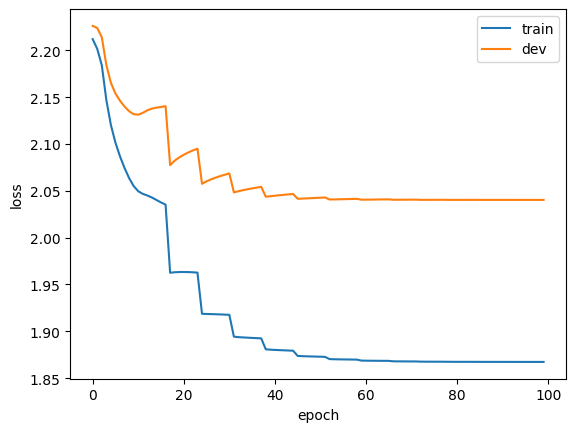

In [21]:
# plot train and dev losses
plt.plot(train_losses, label = 'train')
plt.plot(dev_losses, label = 'dev')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()

In [22]:
print(f"Training Loss: {split_loss('train', model):0.3f}")
print(f"Validation Loss: {split_loss('valid', model):0.3f}")
print(f"Test Loss: {split_loss('test', model):0.3f}")

Training Loss: 1.867
Validation Loss: 2.040
Test Loss: 2.053


In [23]:
sample(model)

malakai
zechya
mahmu
yasanon
ashia
quinnco
bransh
matem
ofciam
saraiya
jayton
aliha
knoor
coty
aldomi
clarlen
jaseer
rayanna
margary
elinn
